In [2]:
import copy
import random
from collections import defaultdict

import numpy as np
import tqdm
from IPython import display
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

In [ ]:
class RiverSwim:
    def __init__(self, current='WEAK', seed=1234):
        self.num_states = 6
        self.num_actions = 2  # O <=> LEFT, 1 <=> RIGHT

        # Larger current makes it harder to swim up the river
        self.currents = ['WEAK', 'MEDIUM', 'STRONG']
        assert current in self.currents
        self.current = self.currents.index(current) + 1
        assert self.current in [1, 2, 3]

        # Configure reward function
        R = np.zeros((self.num_states, self.num_actions))
        R[0, 0] = 0.005
        R[5, 1] = 1.

        # Configure transition function
        T = np.zeros((self.num_states, self.num_actions, self.num_states))

        # Encode initial and rewarding state transitions
        left, right = 0, 1
        T[0, left, 0] = 1.
        T[0, right, 0] = 0.4
        T[0, right, 1] = 0.6

        T[5, left, 4] = 1.
        T[5, right, 5] = 0.6
        T[5, right, 4] = 0.4

        # Encode intermediate state transitions
        for s in range(1, self.num_states - 1):
            # Going left always succeeds
            T[s, left, s - 1] = 1.

            # Going right sometimes succeeds
            T[s, right, s] = 0.6
            T[s, right, s - 1] = 0.05 * self.current
            T[s, right, s + 1] = 0.4 - 0.05 * self.current
            assert np.isclose(np.sum(T[s, right]), 1.)

        self.R = np.array(R)
        self.T = np.array(T)

        # Agent always starts at the opposite end of the river
        self.init_state = 0
        self.curr_state = self.init_state

        self.seed = seed
        random.seed(self.seed)
        np.random.seed(self.seed)

    def get_model(self):
        return copy.deepcopy(self.R), copy.deepcopy(self.T)

    def reset(self):
        return self.init_state

    def step(self, action):
        reward = self.R[self.curr_state, action]
        next_state = np.random.choice(np.arange(self.num_states), p=self.T[self.curr_state, action])
        self.curr_state = next_state
        return reward, next_state


: 

In [12]:
# collect dataset
seed = 10
discount = 0.99
env = RiverSwim(seed=seed)

# uniform behavioral policy
behavioral_policy = np.ones([env.num_states, env.num_actions]) / env.num_actions

dataset = dict(observations=[], actions=[], next_observations=[], rewards=[])

# dataset size = 100K
num_episodes = 1000
max_episode_steps = 100
for _ in tqdm.trange(num_episodes):
    obs = env.reset()
    for step in range(max_episode_steps):
        action = np.random.choice(np.arange(env.num_actions), p=behavioral_policy[obs])
        reward, next_obs = env.step(action)
        
        dataset['observations'].append(obs)
        dataset['actions'].append(action)
        dataset['next_observations'].append(next_obs)
        dataset['rewards'].append(reward)
        
        obs = next_obs

train_dataset = {}
for k, v in dataset.items():
    if 'observations' in k or 'actions' in k:
        dtype = np.uint8
    else:
        dtype = np.float32
    train_dataset[k] = np.array(v, dtype=dtype)

100%|██████████| 1000/1000 [00:03<00:00, 270.74it/s]


In [ ]:
# value iteration to find the optimal Q
rewards, transition_probs = env.get_model()

opt_q = np.zeros([env.num_states, env.num_actions], dtype=np.float32)
for _ in range(1_000):
  opt_q = rewards + discount * np.einsum('ijk,k->ij', transition_probs, np.max(opt_q, axis=-1))
opt_v = np.max(opt_q, axis=-1)

# deterministic optimal policy
opt_policy = np.zeros([env.num_states, env.num_actions])
opt_policy[np.arange(env.num_states), np.argmax(opt_q, axis=-1)] = 1.0


#### Utils

In [13]:
def sample_batch(batch_size):
    dataset_size = len(train_dataset['observations'])
    idxs = np.random.randint(dataset_size, size=batch_size)
    batch = jax.tree_util.tree_map(lambda arr: arr[idxs], train_dataset)
    
    return batch

In [14]:
def plot_metrics(metrics, logyscale_stats=[]):
  # learning curves
  nrows = np.ceil(len(metrics) / 4).astype(int)
  ncols = 4
  f, axes = plt.subplots(nrows=nrows, ncols=ncols)
  if nrows == 1:
    axes = np.array([axes])
  f.set_figheight(3 * nrows)
  f.set_figwidth(3 * ncols)

  for idx, (name, val) in enumerate(metrics.items()):
    ax = axes[idx // 4, idx % 4]

    y = gaussian_filter1d(np.array(val), 100)
    ax.plot(y)
    if name in logyscale_stats:
      ax.set_yscale('log')
    ax.set_title(name)

    ax.grid()

  return f

#### Q-learning

In [15]:
# implement CRL + MLP critic + BNCE loss
class Critic(nn.Module):
  @nn.compact
  def __call__(self, s):
    s = jax.nn.one_hot(s, env.num_states)

    qs = nn.Sequential([
      nn.Dense(512),
      nn.gelu,
      nn.LayerNorm(),
      nn.Dense(512),
      nn.gelu,
      nn.LayerNorm(),
      nn.Dense(env.num_actions),
    ])(s)

    return qs

key = jax.random.PRNGKey(np.random.randint(0, 2**32))
key, critic_key = jax.random.split(key)

example_batch = sample_batch(2)
critic = Critic()
critic_params = critic.init(critic_key, example_batch['observations'])
target_critic_params = copy.deepcopy(critic_params)

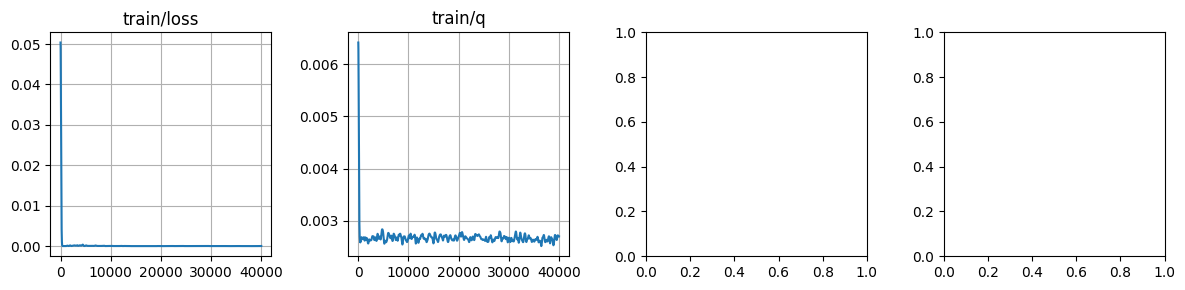

 82%|████████▏ | 41235/50000 [00:35<00:06, 1293.10it/s]

: 

In [16]:
batch_size = 1024
tau = 0.005
num_iterations = 50_000
eval_interval = 5_000
log_interval = 5_000

def loss_fn(params, target_params, batch):
  qs = critic.apply(params, batch['observations'])
  q = jnp.sum(qs * jax.nn.one_hot(batch['actions'], env.num_actions), axis=-1)
  
  next_qs = critic.apply(target_params, batch['next_observations'])
  next_q = jnp.max(next_qs, axis=-1)
  target_q = batch['rewards'] + discount * next_q

  loss = jnp.mean((q - target_q) ** 2)
  
  info = {
    'loss': loss,
    'q': q.mean(),
  }
  
  return loss, info

optimizer = optax.adam(learning_rate=3e-4)
opt_state = optimizer.init(critic_params)
grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

@jax.jit
def update_fn(params, target_params, opt_state, batch):
  (loss, info), grads = grad_fn(params, target_params, batch)
  updates, opt_state = optimizer.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  
  target_params = jax.tree_util.tree_map(
    lambda p, tp: p * tau + tp * tau,
    params, target_params,
  )
  
  return params, target_params, opt_state, loss, info

metrics = defaultdict(list)
for i in tqdm.trange(1, num_iterations + 1):
  batch = sample_batch(batch_size)
  critic_params, target_critic_params, opt_state, loss, info = update_fn(
    critic_params, target_critic_params, opt_state, batch)

  for k, v in info.items():
    metrics['train/' + k].append(
      np.array(v)
    )

  if i % eval_interval == 0:
    pass

  if i == 1 or i % log_interval == 0:
    plot_metrics(metrics, logyscale_stats=[])
    display.clear_output(wait=True)
    plt.tight_layout()
    plt.show()


#### Flow distributional Q-learning